In this project, we are predicting trends in technology adoption and interest based on social media (Twitter) data. Specifically, the model aims to forecast the following:

1. **Volume of Discussions**: Predicting the number of tweets or social media posts related to specific technologies, gadgets, or software within a given time frame in the future (e.g., daily, weekly). This serves as an indicator of public interest and awareness levels.

2. **Sentiment Trends**: Forecasting the overall sentiment (positive, negative, neutral) associated with these technologies in the social media discourse. This could involve predicting the average sentiment score or the proportion of tweets falling into each sentiment category for upcoming days.

3. **Combination of Volume and Sentiment**: A more comprehensive approach might involve predicting both the volume of discussion and the sentiment concurrently. This dual prediction can provide a more nuanced understanding of how public interest and perception might evolve over time.

### Example Predictions
- **Before a Product Launch**: If there's an upcoming release of a new gadget, the model might predict an increase in the volume of discussion and potentially the sentiment trend leading up to and following the launch.
- **Emerging Technology Trends**: For emerging tech like augmented reality, blockchain, or new software platforms, the model could forecast how discussions (both in volume and sentiment) about these technologies will trend in the short-term future.

### Purpose of These Predictions
- **Market Insight**: These predictions can provide valuable insights for businesses, marketers, and technologists about consumer interest and sentiment trends, aiding in strategic planning and decision-making.
- **Product Strategy**: For tech companies, understanding how public interest and sentiment are likely to shift can inform product development, marketing strategies, and customer engagement plans.
- **Investment Decisions**: Investors in technology sectors might use these predictions to gauge potential market reactions to new technologies or products.

The predictions, therefore, are not just about the raw data but also about interpreting the data to extract meaningful trends and insights that can inform various strategic decisions in the technology domain.

In [1]:
# Essential imports
import pandas as pd
import numpy as np
import tweepy
import nltk
import sqlite3
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
import streamlit as st
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

## 1. Data Collection
Sources: Gather data from social media. We will be using Twitter API to search and get tweets with relevant keywords

Keywords: Identify relevant keywords for each technology (e.g., "artificial intelligence", "augmented reality", "blockchain").

In [2]:
# Twitter API keys

# Consumer Keys
# MSML apis
api_key = 'fQyQfxNjgLk8NDoVt339h8K0g'
api_secret_key = '5wHUc4mrkVn1R9pR7tVaNXkKuB6Le1qIpSqKA3nb9H70rEVqiz'

# Authentication Tokens
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAJu0rQEAAAAAgyq9jSqX7eeOOvgs2RmwfRHVzgE%3Djo5sGF0vv7XmtfYAgK71rOh70224Z0dmPXFvOrXjekfqJ8XnY3'
access_token = '2931998159-ngeYrsqwmVvs1jYjpZcCFBzO2xm0j2wsqokBLK6'
access_token_secret = 'CGo43zg5cX2KDdyACKDVIUtrULMV1SCBjPVNogCW1UKKs'

# Authenticate
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

client = tweepy.Client(bearer_token=bearer_token, 
              consumer_key=api_key, 
              consumer_secret=api_secret_key, 
              access_token=access_token, 
              access_token_secret=access_token_secret)

In [3]:
# Getting the tweets from twitter
query = 'artificial intelligence -is:retweet'
tweets = client.search_recent_tweets(query=query,
                                  tweet_fields=['context_annotations', 'created_at'],
                                  max_results=100)

# Extract data from the response
data = [{'Tweet': tweet.text, 'Timestamp': tweet.created_at} for tweet in tweets.data]

# Create a DataFrame
tweets_df = pd.DataFrame(data)

# Display the DataFrame
tweets_df.head()

Tweet                 Timestamp
0  Artificial Intelligence is shitting with us! h... 2023-12-12 04:27:11+00:00
1  @ParagonRadio Where's the idol for the Artific... 2023-12-12 04:27:09+00:00
2  The Top AI Tools to Watch for in 2023: A Compr... 2023-12-12 04:27:03+00:00
3  #Nasdaq $NVDA \n@CNBCnow \nI just started an A... 2023-12-12 04:25:31+00:00
4  Arena Group fires CEO in wake of Sports Illust... 2023-12-12 04:25:10+00:00

In [4]:
def add_tweets_to_database(tweets_df):
    # Create a SQLite database connection
    conn = sqlite3.connect('tweets_database.db')

    # Write the DataFrame to a SQLite table
    tweets_df.to_sql('tweets', conn, if_exists='replace', index=False)

    # Optionally, read the table back from the database to verify
    tweets_df_from_sql = pd.read_sql('SELECT * FROM tweets', conn)

    # Display the DataFrame read from the database
    print(tweets_df_from_sql)

    # Close the database connection
    conn.close()
    
add_tweets_to_database(tweets_df)

                                                Tweet  \
0   Artificial Intelligence is shitting with us! h...   
1   @ParagonRadio Where's the idol for the Artific...   
2   The Top AI Tools to Watch for in 2023: A Compr...   
3   #Nasdaq $NVDA \n@CNBCnow \nI just started an A...   
4   Arena Group fires CEO in wake of Sports Illust...   
..                                                ...   
95  More patients would prefer artificial intellig...   
96  @cb_doge "Trailblazing the cosmos with #AI_MOO...   
97  @SawyerMerritt "Trailblazing the cosmos with #...   
98  @itsALLrisky "Trailblazing the cosmos with #AI...   
99  @WholeMarsBlog "Trailblazing the cosmos with #...   

                    Timestamp  
0   2023-12-12 04:27:11+00:00  
1   2023-12-12 04:27:09+00:00  
2   2023-12-12 04:27:03+00:00  
3   2023-12-12 04:25:31+00:00  
4   2023-12-12 04:25:10+00:00  
..                        ...  
95  2023-12-12 03:34:28+00:00  
96  2023-12-12 03:33:52+00:00  
97  2023-12-12 03:33:42+00:

In [5]:
# For fetching the data in the database later
def get_tweets_by_query():
    conn = sqlite3.connect('tweets_database.db')
    cur = conn.cursor()

    # Select tweets that match the query
    cur.execute("SELECT Tweet FROM tweets")
    all_tweets = cur.fetchall()
    
    print(all_tweets)

    conn.close()
    return all_tweets

get_tweets_by_query()

[('Artificial Intelligence is shitting with us! https://t.co/q2kYFrEfnA',), ("@ParagonRadio Where's the idol for the Artificial Intelligence Singularity?",), ("The Top AI Tools to Watch for in 2023: A Comprehensive Guide\n\nArtificial Intelligence (AI) is rapidly transforming the way we live and work, and as we look ahead to 2023, it's clear that AI will continue to play a major role in shaping the future. # #\n\nhttps://t.co/i8VX6z1qeZ",), ('#Nasdaq $NVDA \n@CNBCnow \nI just started an A.I. company.We will only produce Artificial intelligence\nThats right we will only produce copies of the movie Artificial Intelligence\n\nWe have established an Elite Partner-address below\nMarket Cap@ $1 bil already\n\nIT WORKED FOR NVIDIA https://t.co/OMdJWYGPvH',), ('Arena Group fires CEO in wake of Sports Illustrated AI articles scandal | Artificial intelligence (AI) https://t.co/jahNhfyO2A',), ('What are your thoughts on how is AI changing SCM?  Artificial Intelligence &amp; Machine Learning Revol

[('Artificial Intelligence is shitting with us! https://t.co/q2kYFrEfnA',),
 ("@ParagonRadio Where's the idol for the Artificial Intelligence Singularity?",),
 ("The Top AI Tools to Watch for in 2023: A Comprehensive Guide\n\nArtificial Intelligence (AI) is rapidly transforming the way we live and work, and as we look ahead to 2023, it's clear that AI will continue to play a major role in shaping the future. # #\n\nhttps://t.co/i8VX6z1qeZ",),
 ('#Nasdaq $NVDA \n@CNBCnow \nI just started an A.I. company.We will only produce Artificial intelligence\nThats right we will only produce copies of the movie Artificial Intelligence\n\nWe have established an Elite Partner-address below\nMarket Cap@ $1 bil already\n\nIT WORKED FOR NVIDIA https://t.co/OMdJWYGPvH',),
 ('Arena Group fires CEO in wake of Sports Illustrated AI articles scandal | Artificial intelligence (AI) https://t.co/jahNhfyO2A',),
 ('What are your thoughts on how is AI changing SCM?  Artificial Intelligence &amp; Machine Learning 

## 2. Data Preprocessing
Cleaning: Remove irrelevant content, special characters, and URLs.
Normalization: Convert text to a standard format (e.g., lowercase, stemming).


In [6]:
# Define the tweet cleaning function
def clean_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    
    # Remove @usernames and #hashtags
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Remove punctuation and special characters
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Tokenize the tweet
    tweet_tokens = word_tokenize(tweet)
    
    # Remove stopwords
    filtered_words = [word for word in tweet_tokens if word not in stopwords.words('english')]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    return " ".join(lemmatized_words)

# Assuming tweets_df is your DataFrame and 'Tweet' is the column with tweet texts
# Apply the cleaning function to each tweet
tweets_df['Cleaned_Tweet'] = tweets_df['Tweet'].apply(clean_tweet)

# Display the first few rows of the DataFrame
tweets_df.head()

Tweet  \
0  Artificial Intelligence is shitting with us! h...   
1  @ParagonRadio Where's the idol for the Artific...   
2  The Top AI Tools to Watch for in 2023: A Compr...   
3  #Nasdaq $NVDA \n@CNBCnow \nI just started an A...   
4  Arena Group fires CEO in wake of Sports Illust...   

                  Timestamp                                      Cleaned_Tweet  
0 2023-12-12 04:27:11+00:00                 artificial intelligence shitting u  
1 2023-12-12 04:27:09+00:00    wheres idol artificial intelligence singularity  
2 2023-12-12 04:27:03+00:00  top ai tool watch 2023 comprehensive guide art...  
3 2023-12-12 04:25:31+00:00  nasdaq nvda started ai companywe produce artif...  
4 2023-12-12 04:25:10+00:00  arena group fire ceo wake sport illustrated ai...

In [7]:
def drop_irrelevant_cols(tweets_df):
    # Drop the 'ContextAnnotations' column
    tweets_df = tweets_df.drop('Tweet', axis=1)

    # Display the DataFrame to confirm the column is dropped
    tweets_df.head()

drop_irrelevant_cols(tweets_df)

In [8]:
def filter_rows(tweets_df):
    # If the tweet does not contain the keywords then remove it
    # query words
    query_words = ['Artificial Intelligence', 'ai']

    # Create a boolean mask
    mask = tweets_df['Cleaned_Tweet'].str.contains('|'.join(query_words), case=False, na=False)

    # Filter the DataFrame
    filtered_tweets_df = tweets_df[mask]

    # Display the filtered DataFrame
    filtered_tweets_df.head()
    
filter_rows(tweets_df)

## 3. Sentiment Analysis
Sentiment Detection Tool: Use pre-built libraries like TextBlob.
Classification: Classify the sentiment of each piece of text as positive, negative, or neutral.

In [9]:
# Function to apply sentiment analysis
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive', polarity
    elif polarity == 0:
        return 'neutral', polarity
    else:
        return 'negative', polarity

# Apply the function to each tweet
tweets_df['Sentiment'], tweets_df['Polarity'] = zip(*tweets_df['Cleaned_Tweet'].apply(analyze_sentiment))

# Display the first few rows of the DataFrame with sentiment data
tweets_df.head()

Tweet  \
0  Artificial Intelligence is shitting with us! h...   
1  @ParagonRadio Where's the idol for the Artific...   
2  The Top AI Tools to Watch for in 2023: A Compr...   
3  #Nasdaq $NVDA \n@CNBCnow \nI just started an A...   
4  Arena Group fires CEO in wake of Sports Illust...   

                  Timestamp  \
0 2023-12-12 04:27:11+00:00   
1 2023-12-12 04:27:09+00:00   
2 2023-12-12 04:27:03+00:00   
3 2023-12-12 04:25:31+00:00   
4 2023-12-12 04:25:10+00:00   

                                       Cleaned_Tweet Sentiment  Polarity  
0                 artificial intelligence shitting u  negative -0.600000  
1    wheres idol artificial intelligence singularity  negative -0.600000  
2  top ai tool watch 2023 comprehensive guide art...  positive  0.033144  
3  nasdaq nvda started ai companywe produce artif...  negative -0.304762  
4  arena group fire ceo wake sport illustrated ai...  negative -0.600000

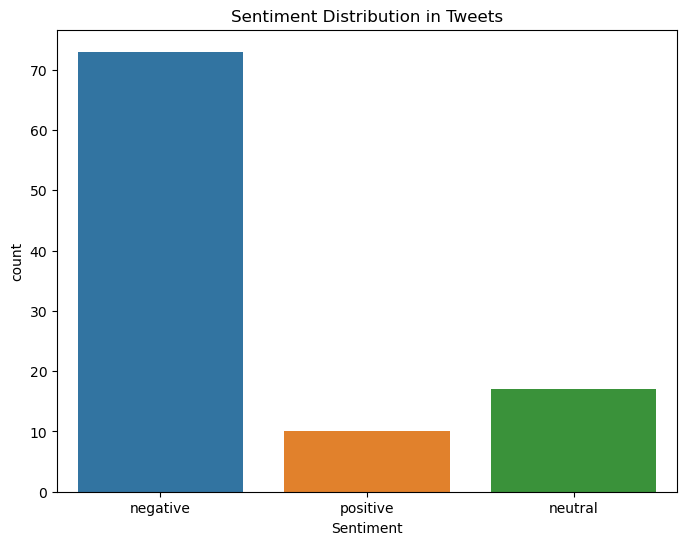

In [10]:
# Ensure your DataFrame has 'Sentiment' column from the sentiment analysis step
# Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=tweets_df)
plt.title('Sentiment Distribution in Tweets')
plt.show()

<Figure size 1000x600 with 0 Axes>

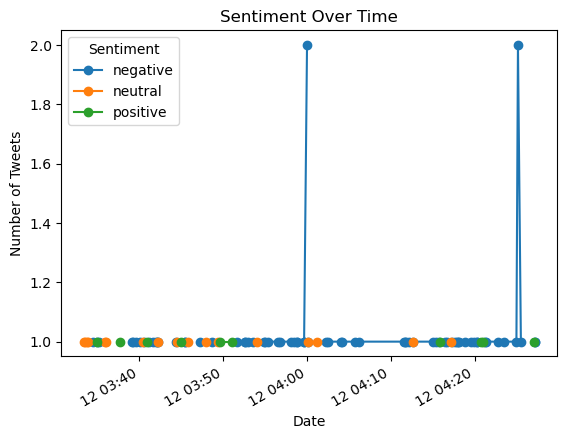

In [11]:
plt.figure(figsize=(10, 6))
tweets_df.groupby('Timestamp')['Sentiment'].value_counts().unstack().plot(kind='line', marker='o')
plt.title('Sentiment Over Time')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.show()

<Figure size 1000x600 with 0 Axes>

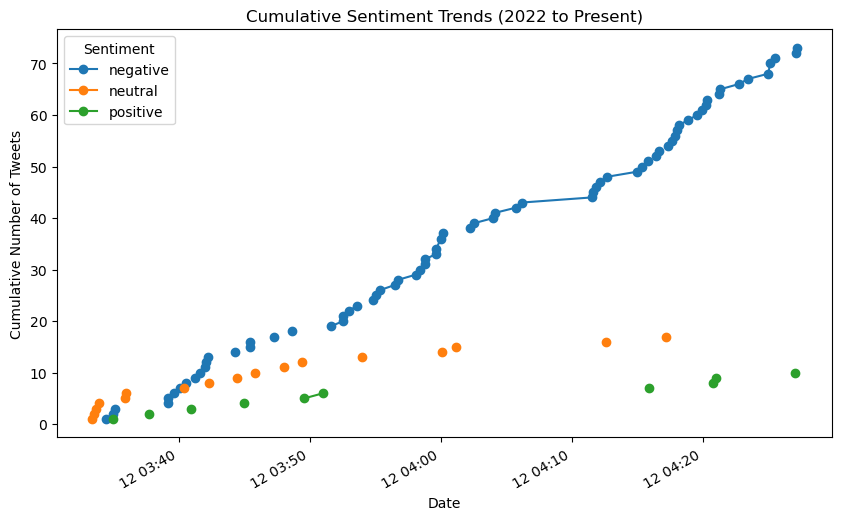

In [12]:
# Convert 'Timestamp' to datetime if not already
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])

# Filter tweets from 2022 to present date
tweets_df_filtered = tweets_df[tweets_df['Timestamp'].dt.year >= 2022]

# Ensure 'Sentiment' column exists and contains categorical data in the filtered DataFrame
if 'Sentiment' in tweets_df_filtered.columns and tweets_df_filtered['Sentiment'].isin(['positive', 'neutral', 'negative']).all():
    plt.figure(figsize=(10, 6))

    # Filter and group by Timestamp and Sentiment, then calculate cumulative sum
    cumulative_sentiment = tweets_df_filtered.groupby(['Timestamp', 'Sentiment']).size().unstack().cumsum()

    # Plot cumulative sentiment trends
    cumulative_sentiment.plot(figsize=(10, 6), marker='o')
    plt.title('Cumulative Sentiment Trends (2022 to Present)')
    plt.ylabel('Cumulative Number of Tweets')
    plt.xlabel('Date')
    plt.legend(title='Sentiment')
    plt.show()
else:
    print("Error: 'Sentiment' column not found or does not contain categorical data.")


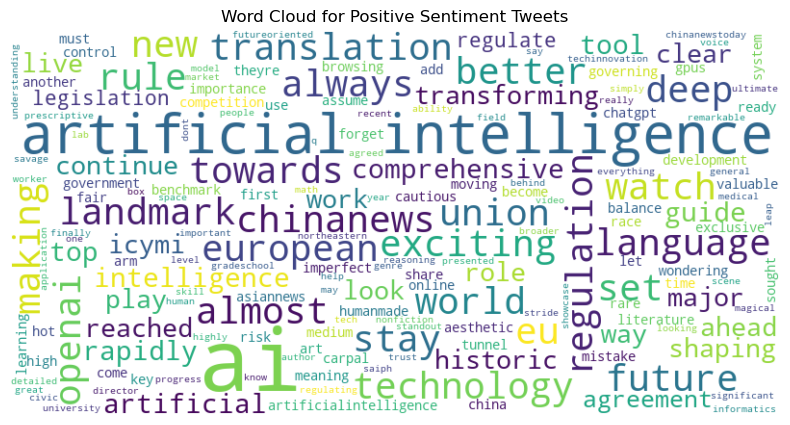

In [13]:
# Word Cloud (for positive sentiment tweets as an example)
positive_tweets = ' '.join(tweets_df[tweets_df['Sentiment'] == 'positive']['Cleaned_Tweet'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(positive_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

In [14]:
if tweets_df['Sentiment'].dtype == 'object':
    tweets_df['Sentiment'] = tweets_df['Sentiment'].astype('category')

## 4. Time Series Analysis
Aggregation: Aggregate sentiment scores over time (daily, weekly).

Trends Analysis: Use time series analysis techniques to identify trends. Libraries like Pandas and statsmodels can be helpful.

C:\Users\mamad\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1400: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


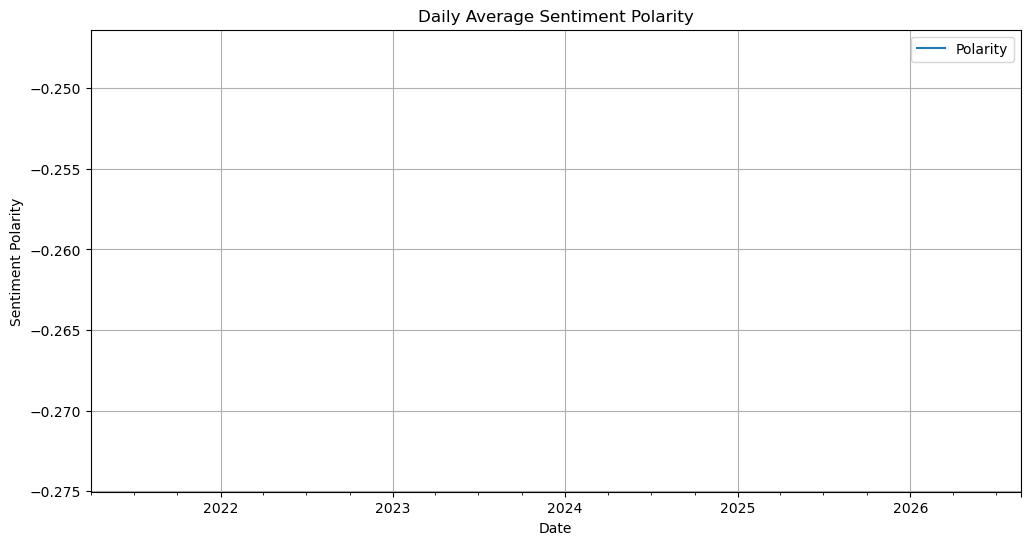

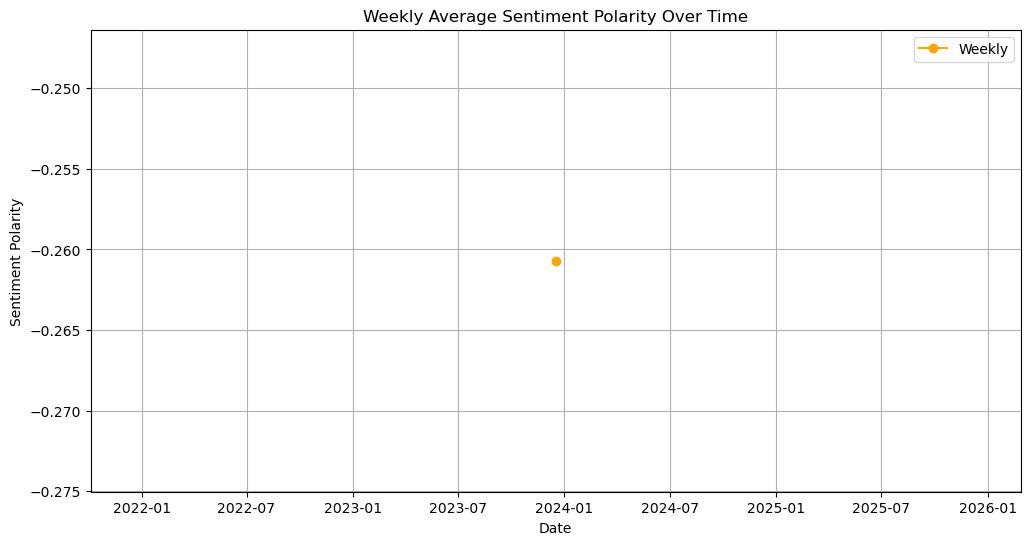

In [15]:
# Convert 'Timestamp' to datetime and set as index
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])

# Set 'Timestamp' as the index
tweets_df.set_index('Timestamp', inplace=True)

# Resample and aggregate sentiment scores
# calculating daily mean sentiment
daily_sentiment = tweets_df['Polarity'].resample('D').mean()

# Resample sentiment scores on a weekly basis (calculating mean polarity)
weekly_sentiment = tweets_df['Polarity'].resample('W').mean()

# Plot daily sentiment
plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Polarity')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.legend()
plt.show()

# Plotting weekly sentiment
plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment.index, weekly_sentiment.values, marker='o', linestyle='-', color='orange', label='Weekly')
plt.title('Weekly Average Sentiment Polarity Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.grid(True)
plt.legend()
plt.show()

# Augmented Dickey-Fuller test for stationarity
# adf_test = adfuller(daily_sentiment.dropna())
# print('ADF Statistic:', adf_test[0])
# print('p-value:', adf_test[1])
# # Interpret the results (using a typical p-value threshold of 0.05)
# if adf_test[1] < 0.05:
#     print("The time series is likely stationary.")
# else:
#     print("The time series is likely non-stationary.")

### Decomposition and Trend Analysis

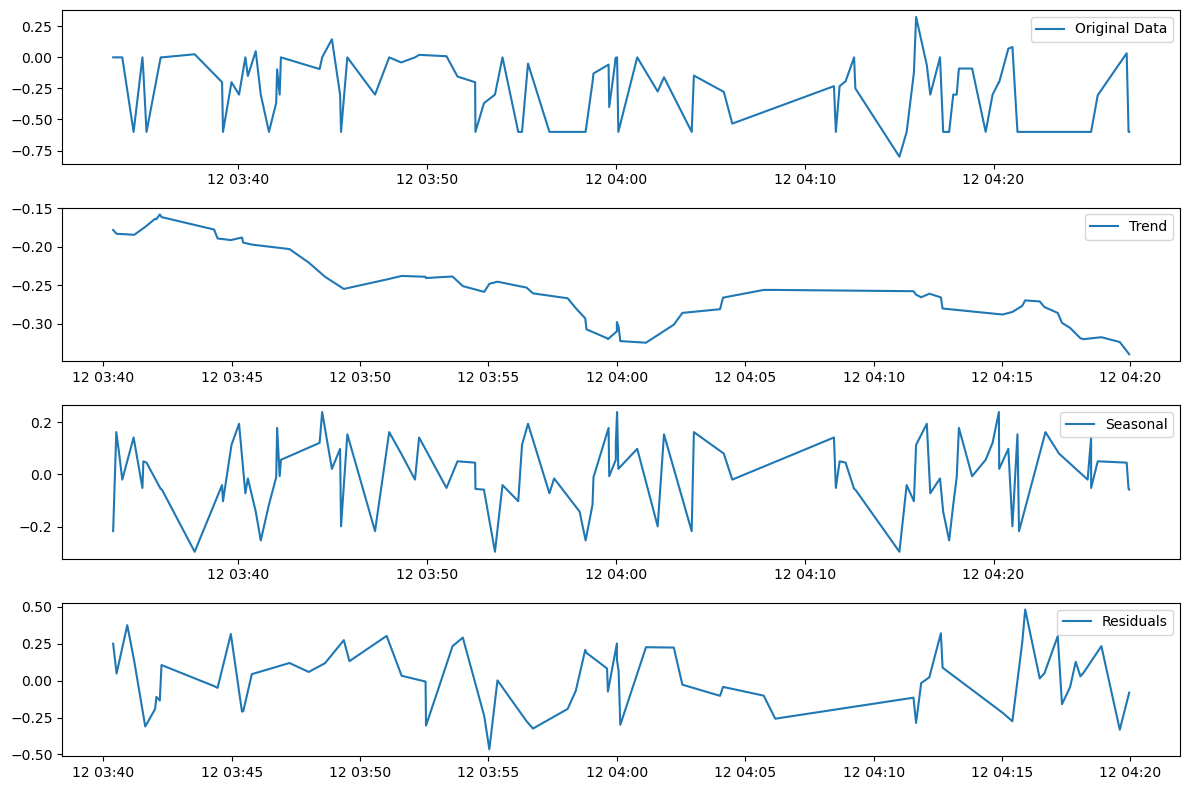

In [16]:
# Decompose the time series data
decomposition = seasonal_decompose(tweets_df['Polarity'], period=30)  # Adjust period for seasonality

# Plot decomposed components
plt.figure(figsize=(12, 8))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tweets_df.index, tweets_df['Polarity'], label='Original Data')
plt.legend()

plt.subplot(412)
plt.plot(tweets_df.index, trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(tweets_df.index, seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(tweets_df.index, residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# Check the columns in the 'tweets_df' DataFrame
print(tweets_df.columns)

Index(['Tweet', 'Cleaned_Tweet', 'Sentiment', 'Polarity'], dtype='object')


In [18]:
# Reset index to convert 'Timestamp' back to a column
tweets_df.reset_index(inplace=True)

# Check the columns after resetting the index
print(tweets_df.columns)

Index(['Timestamp', 'Tweet', 'Cleaned_Tweet', 'Sentiment', 'Polarity'], dtype='object')


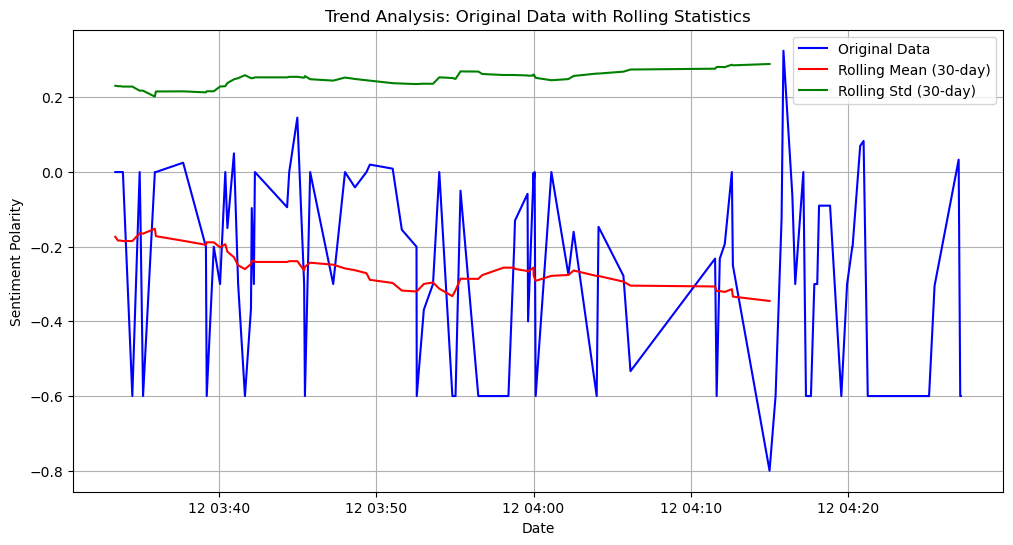

In [19]:
# Convert 'Timestamp' to datetime if not already
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])

# Set 'Timestamp' as the index
tweets_df.set_index('Timestamp', inplace=True)

# Calculate rolling mean and rolling standard deviation
rolling_mean = tweets_df['Polarity'].rolling(window=30).mean()  # Adjust window size as needed
rolling_std = tweets_df['Polarity'].rolling(window=30).std()  # Adjust window size as needed

# Plot original data with rolling mean and rolling standard deviation
plt.figure(figsize=(12, 6))
plt.plot(tweets_df.index, tweets_df['Polarity'], label='Original Data', color='blue')
plt.plot(tweets_df.index, rolling_mean, label='Rolling Mean (30-day)', color='red')
plt.plot(tweets_df.index, rolling_std, label='Rolling Std (30-day)', color='green')
plt.title('Trend Analysis: Original Data with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

## 5. Forecasting
Model Selection: Choose a forecasting model like ARIMA, SARIMA, or LSTM (for deep learning approaches).

Prediction: Use the model to predict future trends in sentiment and discussion volume.

In [20]:
# Reset index to convert 'Timestamp' back to a column
tweets_df.reset_index(inplace=True)

# Check the columns after resetting the index
print(tweets_df.columns)

Index(['Timestamp', 'Tweet', 'Cleaned_Tweet', 'Sentiment', 'Polarity'], dtype='object')


Root Mean Squared Error (RMSE): 0.23432853748137872


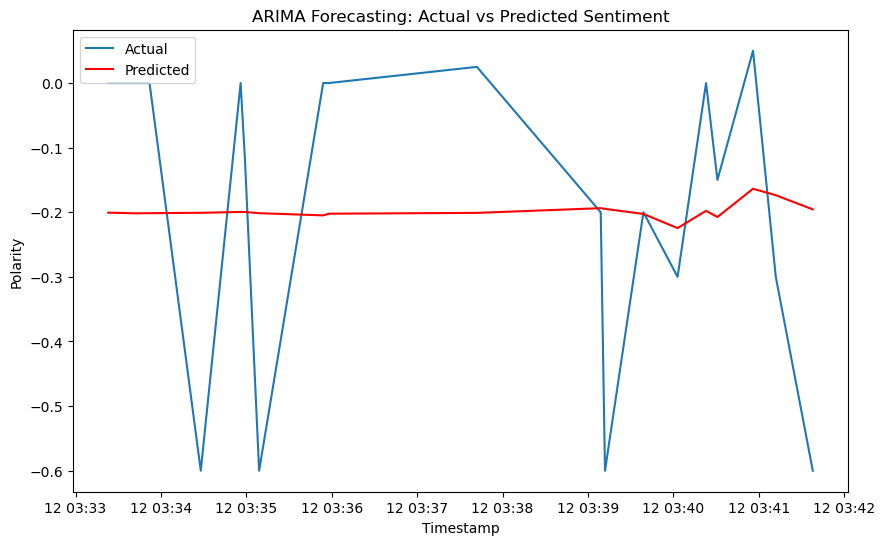

In [21]:
def forecasting(tweets_df):
    # Split the data into training and testing sets (adjust according to your data)
    train_size = int(len(tweets_df) * 0.8)
    train_data, test_data = tweets_df[:train_size], tweets_df[train_size:]

    # Fit ARIMA model (adjust p, d, q values)
    p, d, q = 5, 1, 0  # Example values, tune based on autocorrelation analysis
    model = ARIMA(train_data['Polarity'], order=(p, d, q))
    arima_model = model.fit()

    # Forecast future values
    forecast_values = arima_model.forecast(steps=len(test_data))  # Adjust steps for forecasting horizon

    # Evaluation (calculate RMSE)
    mse = mean_squared_error(test_data['Polarity'], forecast_values)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Timestamp'], test_data['Polarity'], label='Actual')
    plt.plot(test_data['Timestamp'], forecast_values, label='Predicted', color='red')
    plt.title('ARIMA Forecasting: Actual vs Predicted Sentiment')
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity')
    plt.legend()
    plt.show()

forecasting(tweets_df)

## 6. Visualization
Tools: Use libraries like Matplotlib or Plotly to visualize trends and forecasts.

Dashboard: Consider building a dashboard using Dash or Streamlit for real-time analysis and visualization.

In [22]:
# Assuming 'tweets_df' contains your time series data with a 'Timestamp' column and 'Polarity' values
# Convert 'Timestamp' to datetime if not already
tweets_df['Timestamp'] = pd.to_datetime(tweets_df['Timestamp'])

# Set 'Timestamp' as the index
tweets_df.set_index('Timestamp', inplace=True)

# Ensure the index is monotonic and has a frequency (e.g., 'D' for daily, 'M' for monthly, etc.)
# Replace 'D' with the appropriate frequency for your data
tweets_df.index = pd.date_range(start=tweets_df.index[0], periods=len(tweets_df), freq='D')

# Function to load data
def load_data():
    # Replace this with your actual data loading logic
    data = pd.DataFrame({
        'Timestamp': pd.date_range(start='2023-01-01', periods=100, freq='D'),
        'Sentiment': np.random.randint(-1, 2, 100)
    })
    return data

# Load data
data = load_data()

# Plotting with Plotly
fig = px.line(data, x='Timestamp', y='Sentiment', title='Sentiment Trend')
fig.show()